 
This notebook
use a stacker classifier (second-level model) to predict the output from the earlier first-level predictions.

In [3]:

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
#from pandas import Series,DataFrame



# numpy, matplotlib, seaborn
import numpy as np
from matplotlib import cm
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid') 
%matplotlib inline


#cmap = cm.get_cmap('Spectral') # Colour map (there are many others)


### Data Visualization and Preprossessing

In [4]:

# load training and testing data as a dataframe
train_df = pd.read_csv("../download/train.csv", dtype={"Age": np.float64}, )
test_df = pd.read_csv("../download/test.csv", dtype={"Age": np.float64}, )

train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
print ("Basic statistical description:")
train_df.describe()

Basic statistical description:


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [4]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [8]:
train_df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [10]:
test_df.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [29]:

#Categorical: Survived, Sex, and Embarked. Ordinal: Pclass.
#Continous: Age, Fare. Discrete: SibSp, Parch.
#Ticket is a mix of numeric and alphanumeric data types. Cabin is alphanumeric.

In [28]:
#Survival


train_df['Survived'].value_counts(normalize=True)

0    0.616162
1    0.383838
Name: Survived, dtype: float64

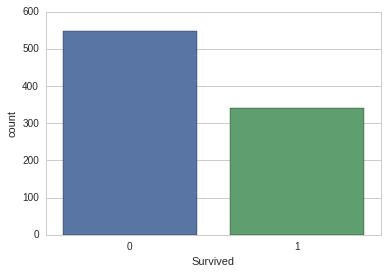

In [5]:
sns.countplot(train_df['Survived'])


In [30]:
combine = [train_df, test_df]
print "After combine", train_df.shape, test_df.shape, combine[0].shape, combine[1].shape


After combine (891, 14) (418, 11) (891, 14) (418, 11)


In [6]:


#Pclass
train_df['Survived'].groupby(train_df['Pclass']).mean()

Pclass
1    0.629630
2    0.472826
3    0.242363
Name: Survived, dtype: float64

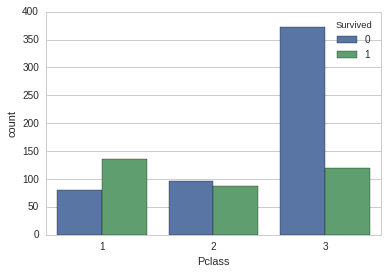

In [7]:
sns.countplot(train_df['Pclass'], hue=train_df['Survived'], order=(1,2,3))

#### Name
The Name column as provided cannot be used in the model.

We are able to extract 'Title' information from it.


In [56]:
train_df['Name'].head(10)

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
5                                     Moran, Mr. James
6                              McCarthy, Mr. Timothy J
7                       Palsson, Master. Gosta Leonard
8    Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)
9                  Nasser, Mrs. Nicholas (Adele Achem)
Name: Name, dtype: object

In [46]:

for i, dataset in enumerate(combine):
    dataset['Title'] = dataset.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
    print (i,dataset['Title'].value_counts())


(0, Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Col           2
Major         2
Mlle          2
Countess      1
Ms            1
Lady          1
Jonkheer      1
Don           1
Mme           1
Capt          1
Sir           1
Name: Title, dtype: int64)
(1, Mr        240
Miss       78
Mrs        72
Master     21
Col         2
Rev         2
Dona        1
Ms          1
Dr          1
Name: Title, dtype: int64)


In [58]:
# Compute a simple cross-tabulation of Title and Sex. 
print pd.crosstab(train_df['Title'], train_df['Sex'])
print '--'
print pd.crosstab(test_df['Title'], test_df['Sex'])


Sex     female  male
Title               
Dr           1     6
Master       0    40
Miss       185     0
Mr           0   517
Mrs        126     0
Rare         2     8
Rev          0     6
--
Sex     female  male
Title               
Dr           0     1
Master       0    21
Miss        79     0
Mr           0   240
Mrs         72     0
Rare         1     2
Rev          0     2


In [52]:

for dataset in combine:
    dataset['Title'] = dataset['Title'].replace(['Col', 'Major', 'Countess', \
                            'Lady', 'Jonkheer', 'Don', 'Capt', 'Sir', 'Dona'], 'Rare')
    
                                                 
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')
    print (i,dataset['Title'].value_counts())

    
#train_df[['Title', 'Survived']].groupby(['Title'], as_index=False).mean()


(1, Mr        517
Miss      185
Mrs       126
Master     40
Rare       10
Dr          7
Rev         6
Name: Title, dtype: int64)
(1, Mr        240
Miss       79
Mrs        72
Master     21
Rare        3
Rev         2
Dr          1
Name: Title, dtype: int64)


In [59]:
grouped = train_df['Survived'].groupby(train_df['Title']).mean()
print grouped.sort_values(axis=0, ascending=False)


Title
Mrs       0.793651
Miss      0.702703
Master    0.575000
Rare      0.500000
Dr        0.428571
Mr        0.156673
Rev       0.000000
Name: Survived, dtype: float64


In [24]:
train_df['Name_Len'] = train_df['Name'].apply(lambda x: len(x))
train_df['Survived'].groupby(pd.qcut(train_df['Name_Len'],5)).mean()

Name_Len
[12, 19]    0.220588
(19, 23]    0.301282
(23, 27]    0.319797
(27, 32]    0.442424
(32, 82]    0.674556
Name: Survived, dtype: float64

In [54]:
#sns.countplot(train_df['Name_Len'])

In [26]:
pd.qcut(train_df['Name_Len'],5).value_counts()

[12, 19]    204
(23, 27]    197
(32, 82]    169
(27, 32]    165
(19, 23]    156
Name: Name_Len, dtype: int64

In [15]:
test_df['Name_Len'] = test_df['Name'].apply(lambda x: len(x))
pd.qcut(test_df['Name_Len'],5).value_counts()

(19, 24]    102
[13, 19]     88
(35, 63]     81
(27, 35]     75
(24, 27]     72
Name: Name_Len, dtype: int64

 SEX

In [61]:

train_df['Sex'].value_counts(normalize=True)
train_df['Survived'].groupby(train_df['Sex']).mean()

0


Sex
female    0.742038
male      0.188908
Name: Survived, dtype: float64

Age

In [63]:
print train_df['Age'].isnull().sum()

train_df['Survived'].groupby(train_df['Age'].isnull()).mean()


177


Age
False    0.406162
True     0.293785
Name: Survived, dtype: float64

In [80]:
#pd.crosstab(train_df['Age'], train_df['Pclass'])

In [18]:
train_df['Survived'].groupby(pd.qcut(train_df['Age'],5)).mean()

Age
[0.42, 19]    0.481707
(19, 25]      0.328467
(25, 31.8]    0.393701
(31.8, 41]    0.437500
(41, 80]      0.373239
Name: Survived, dtype: float64

In [19]:
pd.qcut(train_df['Age'],5).value_counts()

[0.42, 19]    164
(31.8, 41]    144
(41, 80]      142
(19, 25]      137
(25, 31.8]    127
Name: Age, dtype: int64

Siblings and Spouse

In [64]:
##########SibSp
print train_df['SibSp'].isnull().sum()

train_df['Survived'].groupby(train_df['SibSp']).mean()

0


SibSp
0    0.345395
1    0.535885
2    0.464286
3    0.250000
4    0.166667
5    0.000000
8    0.000000
Name: Survived, dtype: float64

In [21]:
train_df['SibSp'].value_counts()

0    608
1    209
2     28
4     18
3     16
8      7
5      5
Name: SibSp, dtype: int64

###### Parents and Children 

In [65]:
###Parch
print train_df['Parch'].isnull().sum()

train_df['Survived'].groupby(train_df['Parch']).mean()

0


Parch
0    0.343658
1    0.550847
2    0.500000
3    0.600000
4    0.000000
5    0.200000
6    0.000000
Name: Survived, dtype: float64

In [23]:
train_df['Parch'].value_counts()

0    678
1    118
2     80
5      5
3      5
4      4
6      1
Name: Parch, dtype: int64

In [66]:
##Ticket
print train_df['Ticket'].isnull().sum()

train_df['Ticket'].head(n=10)

0


0           A/5 21171
1            PC 17599
2    STON/O2. 3101282
3              113803
4              373450
5              330877
6               17463
7              349909
8              347742
9              237736
Name: Ticket, dtype: object

In [25]:
train_df['Ticket_Len'] = train_df['Ticket'].apply(lambda x: len(x))
train_df['Ticket_Len'].value_counts()

6     419
5     131
4     101
8      76
10     41
7      27
9      26
17     14
16     11
13     10
12     10
15      9
11      8
18      6
3       2
Name: Ticket_Len, dtype: int64

In [26]:
train_df['Ticket_Lett'] = train_df['Ticket'].apply(lambda x: str(x)[0])
train_df['Ticket_Lett'].value_counts()

3    301
2    183
1    146
S     65
P     65
C     47
A     29
W     13
4     10
7      9
F      7
6      6
L      4
5      3
8      2
9      1
Name: Ticket_Lett, dtype: int64

In [27]:
train_df.groupby(['Ticket_Lett'])['Survived'].mean()

Ticket_Lett
1    0.630137
2    0.464481
3    0.239203
4    0.200000
5    0.000000
6    0.166667
7    0.111111
8    0.000000
9    1.000000
A    0.068966
C    0.340426
F    0.571429
L    0.250000
P    0.646154
S    0.323077
W    0.153846
Name: Survived, dtype: float64

In [78]:
#######
#Fare
print train_df['Fare'].isnull().sum()
print test_df['Fare'].isnull().sum()


pd.qcut(train_df['Fare'], 3).value_counts()

0
1


[0, 8.662]       308
(26, 512.329]    295
(8.662, 26]      288
Name: Fare, dtype: int64

In [29]:
train_df['Survived'].groupby(pd.qcut(train_df['Fare'], 3)).mean()

Fare
[0, 8.662]       0.198052
(8.662, 26]      0.402778
(26, 512.329]    0.559322
Name: Survived, dtype: float64

In [30]:
pd.crosstab(pd.qcut(train_df['Fare'], 5), columns=train_df['Pclass'])

Pclass,1,2,3
Fare,,,
"[0, 7.854]",6,6,167
"(7.854, 10.5]",0,24,160
"(10.5, 21.679]",0,80,92
"(21.679, 39.688]",64,64,52
"(39.688, 512.329]",146,10,20


In [74]:
#Cabin
# Feature Cabin is highly incomplete. Drop it. 
print train_df['Cabin'].shape[0]
print train_df['Cabin'].isnull().sum()/np.float(train_df['Cabin'].shape[0])
print test_df['Cabin'].isnull().sum()/np.float(test_df['Cabin'].shape[0])



#train_df['Cabin_Letter'] = train_df['Cabin'].apply(lambda x: str(x)[0])
#train_df['Cabin_Letter'].value_counts()

891
0.771043771044
0.782296650718


In [32]:
train_df['Survived'].groupby(train_df['Cabin_Letter']).mean()

Cabin_Letter
A    0.466667
B    0.744681
C    0.593220
D    0.757576
E    0.750000
F    0.615385
G    0.500000
T    0.000000
n    0.299854
Name: Survived, dtype: float64

In [33]:
#Cabin Number


train_df['Cabin_num'] = train_df['Cabin'].apply(lambda x: str(x).split(' ')[-1][1:])
train_df['Cabin_num'].replace('an', np.NaN, inplace = True)
train_df['Cabin_num'] = train_df['Cabin_num'].apply(lambda x: int(x) if not pd.isnull(x) and x != '' else np.NaN)



In [34]:
pd.qcut(train_df['Cabin_num'],3).value_counts()

(65.667, 148]       67
[2, 28.667]         67
(28.667, 65.667]    66
Name: Cabin_num, dtype: int64

In [35]:
train_df['Survived'].groupby(pd.qcut(train_df['Cabin_num'], 3)).mean()

Cabin_num
[2, 28.667]         0.716418
(28.667, 65.667]    0.651515
(65.667, 148]       0.641791
Name: Survived, dtype: float64

In [36]:
train_df['Survived'].corr(train_df['Cabin_num'])

-0.063845959227893656

##### Embarked

In [77]:
print train_df['Embarked'].isnull().sum()

train_df['Embarked'].value_counts()

2


S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [39]:
train_df['Embarked'].value_counts(normalize=True)

S    0.724409
C    0.188976
Q    0.086614
Name: Embarked, dtype: float64

In [40]:
train_df['Survived'].groupby(train_df['Embarked']).mean()

Embarked
C    0.553571
Q    0.389610
S    0.336957
Name: Survived, dtype: float64

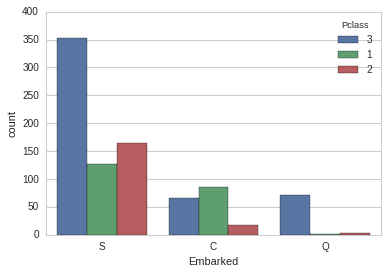

In [41]:
sns.countplot(train_df['Embarked'], hue=train_df['Pclass'])

In [42]:
##########
#Feature Engineering

In [43]:
def names(train_df, test_df):
    for dataset in [train_df, test_df]:
        dataset['Name_Len'] = dataset['Name'].apply(lambda x: len(x))
        dataset['Name_Title'] = dataset['Name'].apply(lambda x: x.split(',')[1]).apply(lambda x: x.split()[0])
        del dataset['Name']
    return train_df, test_df


In [44]:
def age_impute(train_df, test_df):
    for dataset in [train_df, test_df]:
        dataset['Age_Null_Flag'] = dataset['Age'].apply(lambda x: 1 if pd.isnull(x) else 0)
        data = train_df.groupby(['Name_Title', 'Pclass'])['Age']
        dataset['Age'] = data.transform(lambda x: x.fillna(x.mean()))
    return train_df, test_df


In [45]:

def fam_size(train_df, test_df):
    for dataset in [train_df, test_df]:
        dataset['Fam_Size'] = np.where((dataset['SibSp']+dataset['Parch']) == 0 , 'Solo',
                           np.where((dataset['SibSp']+dataset['Parch']) <= 3,'Nuclear', 'Big'))
        del dataset['SibSp']
        del dataset['Parch']
    return train_df, test_df



In [46]:
def ticket_grouped(train_df, test_df):
    for dataset in [train_df, test_df]:
        dataset['Ticket_Lett'] = dataset['Ticket'].apply(lambda x: str(x)[0])
        dataset['Ticket_Lett'] = dataset['Ticket_Lett'].apply(lambda x: str(x))
        dataset['Ticket_Lett'] = np.where((dataset['Ticket_Lett']).isin(['1', '2', '3', 'S', 'P', 'C', 'A']), dataset['Ticket_Lett'], np.where((dataset['Ticket_Lett']).isin(['W', '4', '7', '6', 'L', '5', '8']),'Low_ticket', 'Other_ticket'))
        dataset['Ticket_Len'] = dataset['Ticket'].apply(lambda x: len(x))
        del dataset['Ticket']
    return train_df, test_df



In [47]:

def cabin(train_df, test_df):
    for dataset in [train_df, test_df]:
        dataset['Cabin_Letter'] = dataset['Cabin'].apply(lambda x: str(x)[0])
        del dataset['Cabin']
    return train_df, test_df


In [48]:
def cabin_num(train_df, test_df):
    for dataset in [train_df, test_df]:
        dataset['Cabin_num1'] = dataset['Cabin'].apply(lambda x: str(x).split(' ')[-1][1:])
        dataset['Cabin_num1'].replace('an', np.NaN, inplace = True)
        dataset['Cabin_num1'] = dataset['Cabin_num1'].apply(lambda x: int(x) if not pd.isnull(x) and x != '' else np.NaN)
        dataset['Cabin_num'] = pd.qcut(train_df['Cabin_num1'],3)
    train_df = pd.concat((train_df, pd.get_dummies(train_df['Cabin_num'], prefix = 'Cabin_num')), axis = 1)
    test_df = pd.concat((test_df, pd.get_dummies(test_df['Cabin_num'], prefix = 'Cabin_num')), axis = 1)
    del train_df['Cabin_num']
    del test_df['Cabin_num']
    del train_df['Cabin_num1']
    del test_df['Cabin_num1']
    return train_df, test_df



In [49]:
def embarked_impute(train_df, test_df):
    for dataset in [train_df, test_df]:
        dataset['Embarked'] = dataset['Embarked'].fillna('S')
    return train_df, test_df



In [50]:
test_df['Fare'].fillna(train_df['Fare'].mean(), inplace = True)


In [51]:
def dummies(train_df, test_df, columns = 
            ['Pclass', 'Sex', 'Embarked', 'Ticket_Lett', 'Cabin_Letter', 'Name_Title', 'Fam_Size']):
    for column in columns:
        train_df[column] = train_df[column].apply(lambda x: str(x))
        test_df[column] = test_df[column].apply(lambda x: str(x))
        good_cols = [column+'_'+dataset for dataset in train_df[column].unique() if dataset in test_df[column].unique()]
        train_df = pd.concat((train_df, pd.get_dummies(train_df[column], prefix = column)[good_cols]), axis = 1)
        test_df = pd.concat((test_df, pd.get_dummies(test_df[column], prefix = column)[good_cols]), axis = 1)
        del train_df[column]
        del test_df[column]
    return train_df, test_df




In [52]:

def drop(train_df, test_df, bye = ['PassengerId']):
    for dataset in [train_df, test_df]:
        for z in bye:
            del dataset[z]
    return train_df, test_df


In [53]:
train_df = pd.read_csv('../download/train.csv')
test_df = pd.read_csv('../download/test.csv')
train_df, test_df = names(train_df, test_df)
train_df, test_df = age_impute(train_df, test_df)
train_df, test_df = cabin_num(train_df, test_df)
train_df, test_df = cabin(train_df, test_df)
train_df, test_df = embarked_impute(train_df, test_df)
train_df, test_df = fam_size(train_df, test_df)
test_df['Fare'].fillna(train_df['Fare'].mean(), inplace = True)
train_df, test_df = ticket_grouped(train_df, test_df)
train_df, test_df = dummies(train_df, test_df, columns = 
                            ['Pclass', 'Sex', 'Embarked', 'Ticket_Lett','Cabin_Letter', 'Name_Title', 'Fam_Size'])


In [54]:
train_df.head(3)

,PassengerId,Survived,Age,Fare,Name_Len,Age_Null_Flag,"Cabin_num_[2, 28.667]","Cabin_num_(28.667, 65.667]","Cabin_num_(65.667, 148]",Ticket_Len,...,Name_Title_Mrs.,Name_Title_Miss.,Name_Title_Master.,Name_Title_Rev.,Name_Title_Dr.,Name_Title_Ms.,Name_Title_Col.,Fam_Size_Nuclear,Fam_Size_Solo,Fam_Size_Big
0,1,0,22.0,7.2500,23,0,0,0,0,9,...,0,0,0,0,0,0,0,1,0,0
1,2,1,38.0,71.2833,51,0,0,0,1,8,...,1,0,0,0,0,0,0,1,0,0
2,3,1,26.0,7.9250,22,0,0,0,0,16,...,0,1,0,0,0,0,0,0,1,0


# Export

In [55]:
train_df.to_csv('./data/preprocessing_train_df.csv')
test_df.to_csv('./data/preprocessing_test_df.csv')
                

# Classifier Comparison

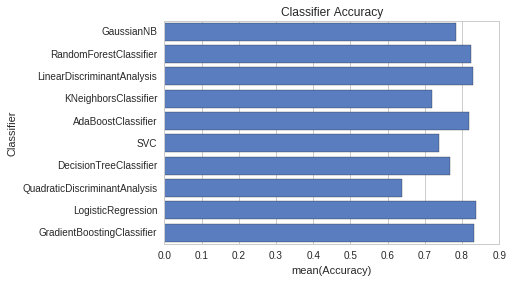

In [56]:
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, log_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression


train_df, test_df = drop(train_df, test_df)


classifiers = [
    KNeighborsClassifier(3),
    SVC(probability=True),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
	AdaBoostClassifier(),
    GradientBoostingClassifier(),
    GaussianNB(),
    LinearDiscriminantAnalysis(),
    QuadraticDiscriminantAnalysis(),
    LogisticRegression()]

log_cols = ["Classifier", "Accuracy"]
log 	 = pd.DataFrame(columns=log_cols)

sss = StratifiedShuffleSplit(n_splits=10, test_size=0.1, random_state=0)

X = train_df.iloc[:, 1:]
y = train_df.iloc[:, 0]

acc_dict = {}

for train_index, test_index in sss.split(X, y):
	X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:]
	y_train, y_test = y[train_index], y[test_index]
	
	for clf in classifiers:
		name = clf.__class__.__name__
		clf.fit(X_train, y_train)
		train_predictions = clf.predict(X_test)
		acc = accuracy_score(y_test, train_predictions)
		if name in acc_dict:
			acc_dict[name] += acc
		else:
			acc_dict[name] = acc

for clf in acc_dict:
	acc_dict[clf] = acc_dict[clf] / 10.0
	log_entry = pd.DataFrame([[clf, acc_dict[clf]]], columns=log_cols)
	log = log.append(log_entry)

    
    
plt.xlabel('Accuracy')
plt.title('Classifier Accuracy')

sns.set_color_codes("muted")
sns.barplot(x='Accuracy', y='Classifier', data=log, color="b")

In [57]:
print log

                      Classifier  Accuracy
0                     GaussianNB  0.784444
0         RandomForestClassifier  0.825556
0     LinearDiscriminantAnalysis  0.831111
0           KNeighborsClassifier  0.718889
0             AdaBoostClassifier  0.818889
0                            SVC  0.737778
0         DecisionTreeClassifier  0.768889
0  QuadraticDiscriminantAnalysis  0.640000
0             LogisticRegression  0.838889
0     GradientBoostingClassifier  0.833333




predictions = rf.predict(test_df)
predictions = pd.DataFrame(predictions, columns=['Survived'])
test = pd.read_csv('./download/test.csv')
predictions = pd.concat((test.iloc[:, 0], predictions), axis = 1)
predictions.to_csv('newoutput.csv', sep=",", index = False)

